In [17]:
import SimpleITK as sitk
import numpy as np
import sigpy as sp
from sigpy import plot
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.interpolate import griddata

sitk_t1 = sitk.ReadImage('t1.nii.gz') 
t1 = sitk.GetArrayFromImage(sitk_t1)
t1_slice=t1[0,0,45,:,:]

print(t1.shape)
print(t1_slice.shape)

(2, 1, 90, 256, 256)
(256, 256)


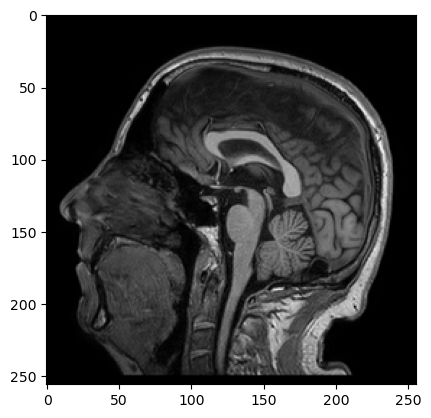

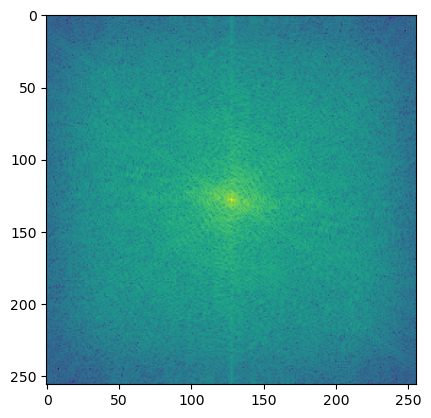

In [18]:
plt.figure()
plt.imshow(t1_slice, cmap='gray')
plt.show()

fft_t1_slice = sp.fft(t1_slice, center=True)
plt.figure()
plt.imshow(np.log10(abs(fft_t1_slice)))
plt.show()


# 1. Simulation of radial sampling: (15%)

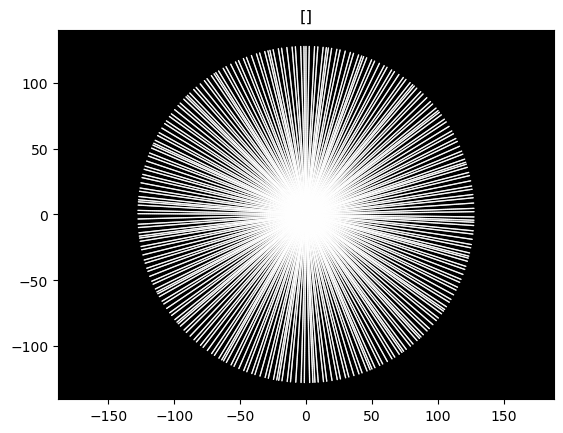

In [19]:
spikes = 256
coord = sp.mri.radial((spikes,256,2),(256,256))

# show spikes used for radial sampling
sp.plot.ScatterPlot(coord)

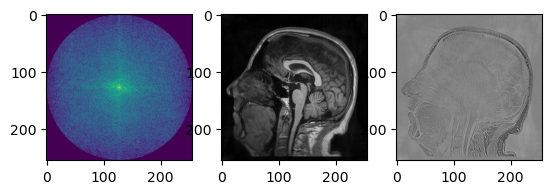

In [20]:
coord = sp.mri.radial((spikes,256,2),(256,256)) + 256/2 # shift coordinates to have only positive coordinates

# radial sampling of the original k-space
k_sp_radial = sp.interpolate(fft_t1_slice, coord)

# setting new grid for interpolation:
grid_x,grid_y = np.mgrid[0:256, 0:256]

# interpolation of sampled points to new grid
points = np.transpose(np.array([coord[:, :, 0].flatten(), coord[:, :, 1].flatten()]))
values = k_sp_radial.flatten()
t1_img_ksp = griddata(points, values, (grid_x, grid_y), method='cubic', fill_value=0)
# reconstruct image using inverse fouriert transform
t1_recon = sp.ifft(t1_img_ksp, center=True)

# plot k-space, reconstruction and difference to original image:
plt.figure()
plt.subplot(131)
plt.imshow(np.log10(abs(t1_img_ksp)+1))

plt.subplot(132)
plt.imshow(abs(t1_recon), cmap='gray')

plt.subplot(133)
plt.imshow(abs(t1_recon)-abs(t1_slice), cmap='gray')
plt.show()


Acceleration factor:  1.0


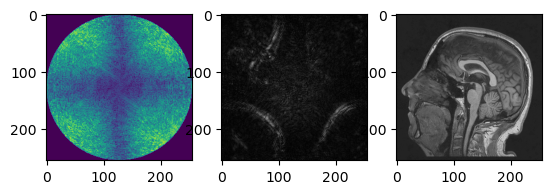

Acceleration factor:  2.0


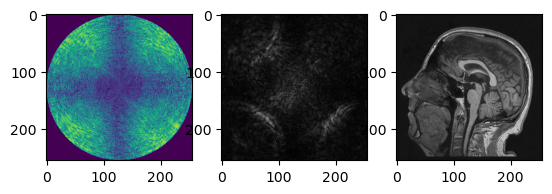

Acceleration factor:  4.0


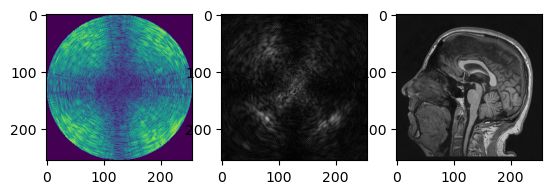

Acceleration factor:  9.846153846153847


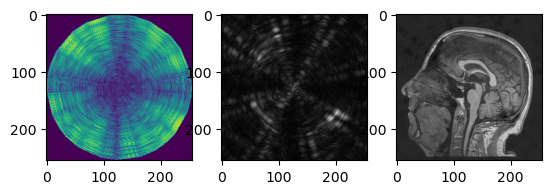

In [28]:
# compute acceleration factor:
# acceleration factor is number of sample points with cartesian sampling divided by number of sampling points with radial points:
# acc = (256*256)/(n_spikes*samples_per_spikes) -> with samples_per_spikes=256:  n_spikes = 256/acc
# acc in [1, 10]: upper boundary: n_spikes >= 256/10 = 25.6; lower boundary: n_spikes <= 256/1 = 256
# --> Values for spikes between 26 and 156 spikes are permissible

n_spikes = [256, 128, 64, 26] # list of number of spikes

ffts = [] # list to store ffts
iffts = [] # list to store subsampled images

# setting new grid for interpolation:
grid_x,grid_y = np.mgrid[0:256, 0:256]

for n in n_spikes:
    coord = sp.mri.radial((n,256,2), (256,256)) + 256/2
    # radial sampling of the original k-space
    tmp_k_sp_radial = sp.interpolate(fft_t1_slice, coord)

    # interpolation of sampled points to new grid
    tmp_points = np.transpose(np.array([coord[:, :, 0].flatten(), coord[:, :, 1].flatten()]))
    tmp_values = tmp_k_sp_radial.flatten()
    tmp_fft = griddata(tmp_points, tmp_values, (grid_x, grid_y), method='cubic', fill_value=0)

    # append to list for further analysis
    ffts.append(tmp_fft)
    iffts.append(abs(sp.ifft(tmp_fft, center=True)))

# plot all ffts and respective iffts
for n, fft, ifft in zip(n_spikes, ffts, iffts):
    print("Acceleration factor: ", 256/n)
    plt.figure()
    plt.subplot(131)
    plt.imshow(np.log10(abs(fft)+1))
    plt.subplot(132)
    plt.imshow(ifft, cmap='gray')
    plt.subplot(133)
    plt.imshow(t1_slice-ifft, cmap='gray')
    plt.show()


## Task 2: Quality assessment (10%)

In [22]:
metrics = np.zeros((len(n_spikes), 2))
for i in range(len(n_spikes)):
    metrics[i][0] = peak_signal_noise_ratio(t1_slice, iffts[i], data_range=(t1_slice.max() - t1_slice.min()))
    metrics[i][1] = structural_similarity(t1_slice, iffts[i], data_range=(t1_slice.max() - t1_slice.min()))
    print("n_spikes: ", n_spikes[i], " ,Acceleration:", 256/n_spikes[i])
    print("PSNR: ", metrics[i][0])
    print("SSIM: ", metrics[i][1])
    print("  ")


n_spikes:  256  ,Acceleration: 1.0
PSNR:  11.178529490856233
SSIM:  0.06422577560811833
  
n_spikes:  128  ,Acceleration: 2.0
PSNR:  11.258934720099234
SSIM:  0.0667534583528264
  
n_spikes:  64  ,Acceleration: 4.0
PSNR:  11.370519877138001
SSIM:  0.07179629159700629
  
n_spikes:  26  ,Acceleration: 9.846153846153847
PSNR:  11.547622325103678
SSIM:  0.07956965739300743
  


# Task 3: Reconstruction with the non-uniform Fourier transform (NUFT): (30%)

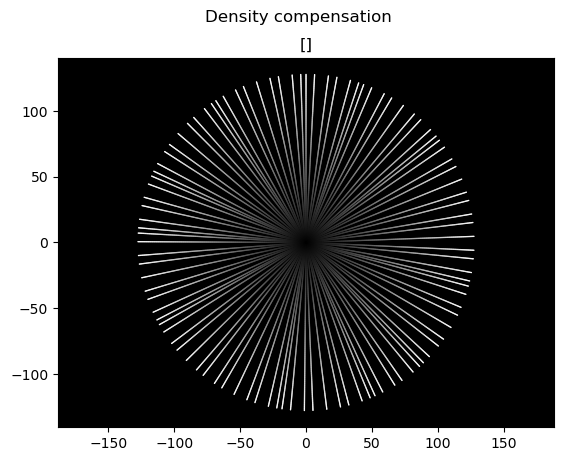

(256, 256)
(100, 256, 2)


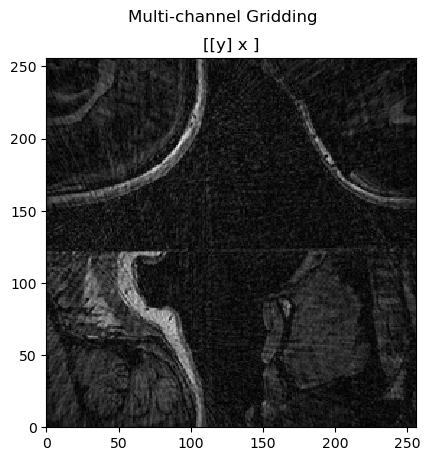

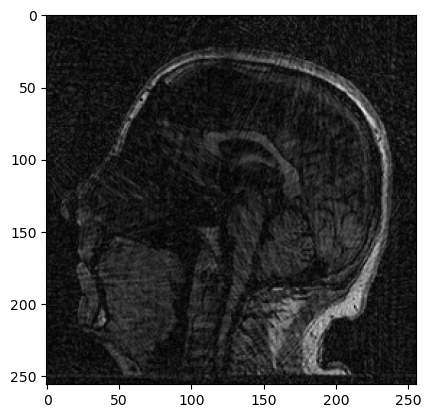

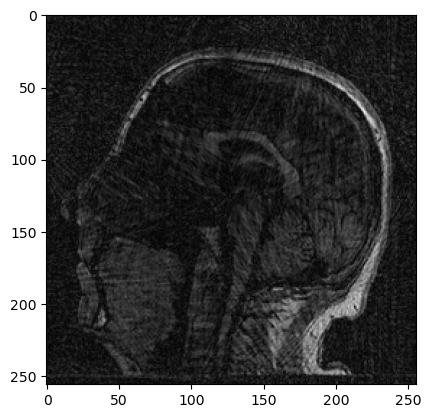

In [23]:
spikes = 100

#fft_t1_slice = sp.fft(t1_slice, center=False)
coord = sp.mri.radial((spikes,256,2), (256,256))
ksp = sp.interpolate(fft_t1_slice, coord)

# density compensated function
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
plot.ScatterPlot(coord, dcf, title='Density compensation')

img_grid = sp.nufft_adjoint(ksp * dcf, coord, oshape=(256, 256))
print(img_grid.shape)
print(coord.shape)
plot.ImagePlot(img_grid, title='Multi-channel Gridding')

img_grid = np.fft.fftshift(img_grid)
plt.imshow(abs(img_grid), cmap="gray")
plt.show()

plt.imshow(abs(img_grid) - t1_slice, cmap="gray")
plt.show()



In [24]:
import importlib

In [25]:
importlib.reload(sp)

<module 'sigpy' from '/Users/lasse/miniforge3/envs/hl2027/lib/python3.8/site-packages/sigpy/__init__.py'>